# Input margin and output margin

"the output margin (the difference between the largest and second-largest logits) and the adversarial input margin (the smallest norm required for an adversarial perturbation in the input to change the model’s class prediction)"

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils
import data_utils

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Output margins

### Utility functions

In [2]:
import torch

def get_output_margins(model, test_loader):
    inpts, targets, predictions, output_margins = [], [], [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            max, predicted = torch.max(outputs, 1)
            srtd_lgts = np.sort(outputs, axis=1)  # sort logits
            #print(outputs.shape)
            #print(srtd_lgts.shape)
            output_margin = srtd_lgts[:, 0]-srtd_lgts[:, 1]

            inpts.extend(inputs)
            targets.extend(labels.detach())
            predictions.extend(predicted.detach())
            output_margins.extend(output_margin)

            #print(max[0], predicted[0], output_margin[0])

    return inpts, targets, predictions, output_margins

In [12]:
def plot_output_margin_histogram(
        output_margins_1, output_margins_2,
        rot_1, rot_2,
        xlim=None, ylim=None,
        config=None):
        
    plt.hist(output_margins_1, bins=200, label='{}°-MNIST'.format(rot_1))
    plt.hist(output_margins_2, bins=200, label='{}°-MNIST'.format(rot_2))


    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.title('0°-{}'.format(config['model_name']), fontsize=18)
    plt.ylabel('Number of examples', fontsize=15)
    plt.xlabel('Output margin', fontsize=15)
    plt.yscale('log')
    plt.legend()
    path = '0_SeparateModel/{}_{}_-0deg_output_margins_comparison_{}deg_vs_{}deg.pdf'.format(
        config['setting'],
        config['model_name'],
        rot_1,
        rot_2
    )
    plt.savefig(path, bbox_inches='tight')
    plt.show()

In [13]:
def plot_pairwise_output_margins(a, b,
                what,
                ylabel, xlabel,
                bins, cmap,
                deg_in, deg_out,
                vmax=None, xlim=None, ylim=None,
                log=False,
                config=None):
    H, xedges, yedges = np.histogram2d(a,b,bins=bins) #,range=histRange)
    #H, xedges, yedges = np.histogram2d(m1,m2,bins=10) #,range=histRange)
    #print(xedges, yedges)

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)
    
    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    # Log
    if log is True:
        Hmasked = np.log10(Hmasked)     

    # Plot 2D histogram using pcolor
    fig2 = plt.figure()
    #plt.pcolormesh(xedges,yedges,Hmasked, cmap='jet')
    plt.pcolormesh(xedges,yedges,Hmasked, cmap=cmap, vmin=0, vmax=vmax)
    plt.colorbar()
    #plt.xticks(range(0,20,200), range(10))
    #plt.yticks(range(10))

    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.title('{}°-{} model'.format(deg_in, config['model_name']), fontsize=18)
    plt.ylabel('({}°-MNIST) {}'.format(deg_out, ylabel), fontsize=15)
    plt.xlabel('({}°-MNIST) {}'.format(deg_in, xlabel), fontsize=15)
    #path = '0_SeparateModel/SeparateModel_SimpleNN_{}deg_how-correct-preds-in-{}deg-MNIST-are-classified-in-{}deg-MNIST.pdf'.format(
    path = '0_SeparateModel/{}_{}_{}deg_{}_{}deg_in_{}deg_out.pdf'.format(
        config['setting'],
        config['model_name'],
        deg_in,
        what,
        deg_in,
        deg_out 
    )
    plt.savefig(path,bbox_inches='tight')
    plt.show()

In [14]:
def run_output_margins_analysis(model_id, config, **kwargs):
    # load dataloaders
    utils.set_seed(0)
    train_loaders, test_loaders = data_utils.create_rotated_mnist_task(
        config['num_tasks'], config['per_task_rotation'], config['batch_size']
        )

    # which model to analyze?
    # model_id = 1

    test_loader_1 = test_loaders[model_id]
    rot_1 = test_loader_1['rot']
    print('rotation_1', rot_1)

    for i in range(config['num_tasks']):
        # if i==model_id:
        #     continue

        #-------------------------------------------------------------- cell 1
        test_loader_2 = test_loaders[i]
        rot_2 = test_loader_2['rot']
        print('rotation_2', rot_2)

        # load model
        model_path = '0_SeparateModel/{}/{}_{}_{}deg_MNIST.pth'.format(
            config['model_name'],
            config['setting'],
            config['model_name'],
            rot_1 
            )
        model = utils.load_model(path=model_path)

        # compute predictions
        inputs_1, targets_1, predictions_1, output_margins_1 = get_output_margins(model, test_loader_1['loader'])
        inputs_2, targets_2, predictions_2, output_margins_2 = get_output_margins(model, test_loader_2['loader'])

        #-------------------------------------------------------------- cell 2
        np_inputs_1 = np.array(inputs_1)
        np_targets_1 = np.array(targets_1)
        np_preds_1 = np.array(predictions_1)
        np_output_margins_1 = np.array(output_margins_1)

        np_inputs_2 = np.array(inputs_2)
        np_targets_2 = np.array(targets_2)
        np_preds_2 = np.array(predictions_2)
        np_output_margins_2 = np.array(output_margins_2)

        #-------------------------------------------------------------- cell 3
        plot_output_margin_histogram(
            np_output_margins_1, np_output_margins_2,
            rot_1, rot_2,
            config=config)

        #-------------------------------------------------------------- cell 4
        plot_pairwise_output_margins(
            np_output_margins_1, np_output_margins_2,
            what='output_margins',
            xlabel='Output margin', ylabel='Output margin',
            bins=100, cmap='jet',
            #vmax=5,
            #xlim=[-25, 0], ylim=[-25, 0],
            xlim=kwargs['xlim'], ylim=kwargs['ylim'],
            deg_in=rot_1, deg_out=rot_2,
            log=False,
            config=config)

### TESTS with SimpleNN

In [2]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


In [26]:
# load dataloaders
utils.set_seed(0)
train_loaders, test_loaders = data_utils.create_rotated_mnist_task(config['num_tasks'], config['per_task_rotation'], config['batch_size'])

test_loader_1 = test_loaders[1]
print('rotation_1', test_loader_1['rot'])
test_loader_2 = test_loaders[2]
print('rotation_2', test_loader_2['rot'])

# load model
model_path = '0_SeparateModel/SimpleNN/SeparateModel_{}_{}deg_MNIST.pth'.format(
    config['model_name'],
    test_loader_1['rot']
    )
model = utils.load_model(path=model_path)

# compute predictions
inputs_1, targets_1, predictions_1, output_margins_1 = get_output_margins(model, test_loader_1['loader'])
inputs_2, targets_2, predictions_2, output_margins_2 = get_output_margins(model, test_loader_2['loader'])

Random seed set as 0
rotation_1 0
rotation_2 45
torch.Size([256, 10])
(256, 10)
tensor(14.8408) tensor(7) -13.104833
torch.Size([256, 10])
(256, 10)
tensor(14.5079) tensor(2) -3.7717924
torch.Size([256, 10])
(256, 10)
tensor(17.1652) tensor(2) -9.1003895
torch.Size([256, 10])
(256, 10)
tensor(10.4759) tensor(1) -3.8405056
torch.Size([256, 10])
(256, 10)
tensor(8.5274) tensor(4) -0.558094
torch.Size([256, 10])
(256, 10)
tensor(7.9619) tensor(1) -0.32017994
torch.Size([256, 10])
(256, 10)
tensor(12.5261) tensor(6) -8.057047
torch.Size([256, 10])
(256, 10)
tensor(14.3793) tensor(7) -8.376647
torch.Size([256, 10])
(256, 10)
tensor(12.7094) tensor(7) -14.80128
torch.Size([256, 10])
(256, 10)
tensor(18.0584) tensor(0) -11.3171835
torch.Size([256, 10])
(256, 10)
tensor(6.5425) tensor(3) -4.314378
torch.Size([256, 10])
(256, 10)
tensor(7.5748) tensor(1) -1.2272615
torch.Size([256, 10])
(256, 10)
tensor(11.6772) tensor(8) -4.6279254
torch.Size([256, 10])
(256, 10)
tensor(13.2896) tensor(7) -4.4

In [27]:
np_inputs_1 = np.array(inputs_1)
np_targets_1 = np.array(targets_1)
np_preds_1 = np.array(predictions_1)
np_output_margins_1 = np.array(output_margins_1)

np_inputs_2 = np.array(inputs_2)
np_targets_2 = np.array(targets_2)
np_preds_2 = np.array(predictions_2)
np_output_margins_2 = np.array(output_margins_2)

/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point

(10000,)


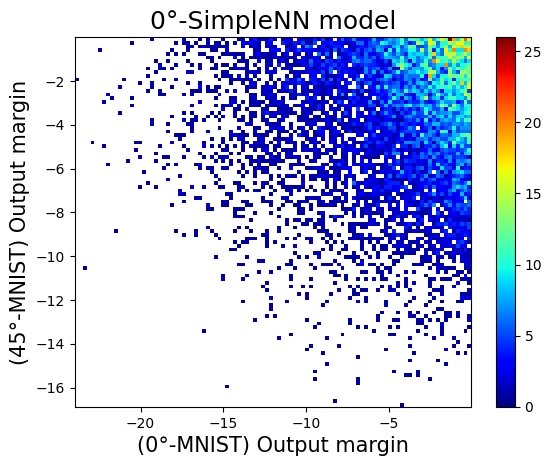

In [34]:
# a = np.array(logits_1)[bien_bien_preds]
# b = np.array(logits_2)[bien_bien_preds]
# 
# assert a.shape==b.shape

print(np_output_margins_1.shape)

plot_pairwise_output_margins(
    np_output_margins_1, np_output_margins_2,
    what='output_margins',
    xlabel='Output margin', ylabel='Output margin',
    bins=100, cmap='jet',
    #vmax=5,
    #xlim=[-30, 0], ylim=[-1.5, 0],
    deg_in=0, deg_out=45,
    log=False,
    config=None)

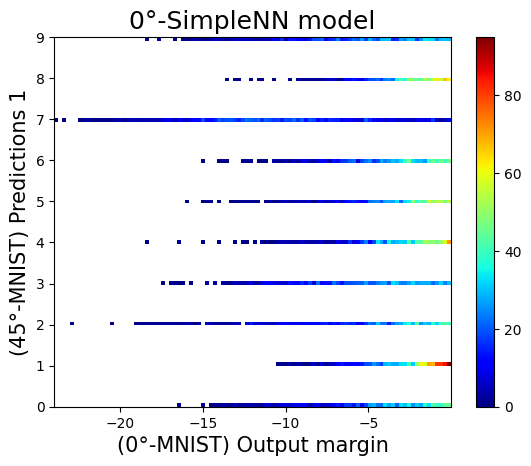

In [35]:

plot_pairwise_output_margins(
    np_output_margins_1, np_preds_1,
    what='output_margins_vs_predictions',
    xlabel='Output margin', ylabel='Predictions 1',
    bins=100, cmap='jet',
    #vmax=5,
    #xlim=[-30, 0], ylim=[-1.5, 0],
    deg_in=0, deg_out=45,
    log=False,
    config=None)

### Automatize the analysis

e.g., **0°**-MNIST x j°-MNIST  with **0°**-SimpleNN

#### SimpleNN

In [ ]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


In [ ]:
run_output_margins_analysis(model_id=1, config=config, xlim=[-25, 0], ylim=[-25, 0])

#### SimpleCNN

In [15]:
config = {
    # ---COMMON----
    'setting': 'SeparateModel',
    'model_name': 'SimpleCNN',
    'num_tasks': 8, 'per_task_rotation': 45,
    # 'trial': TRIAL_ID, 'exp_dir': EXP_DIR,\
    # 'memory_size': 200, 'dataset': DATASET, 'device': DEVICE, 'momentum': 0.8,\
    # 'mlp_hiddens': HIDDENS, 'dropout': 0.2, 'lr_decay': 0.8, 'stable_sgd': False,\
    'batch_size': 64,\
    'rounds': 10
}
config['rotations'] = [(task-1) * config['per_task_rotation'] for task in range(config['num_tasks'])]  #consistent with the code of `create_rotated_mnist`
print(config['rotations'])


[-45, 0, 45, 90, 135, 180, 225, 270]


Random seed set as 0
rotation_1 0
rotation_2 -45


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

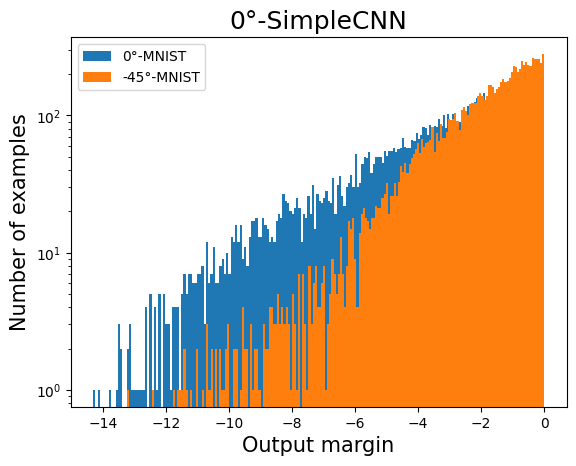

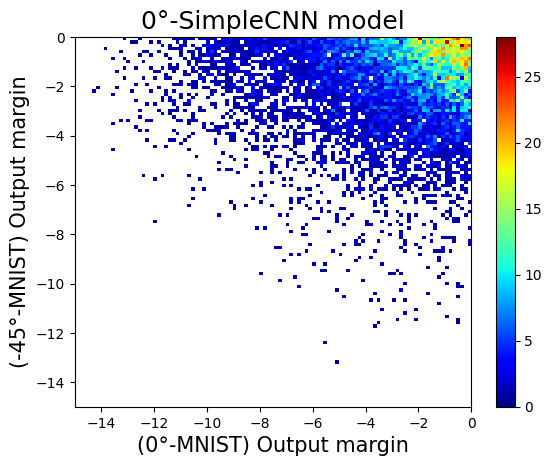

rotation_2 0


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

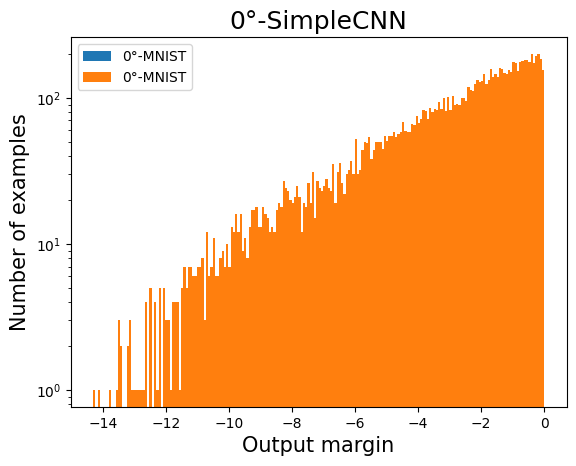

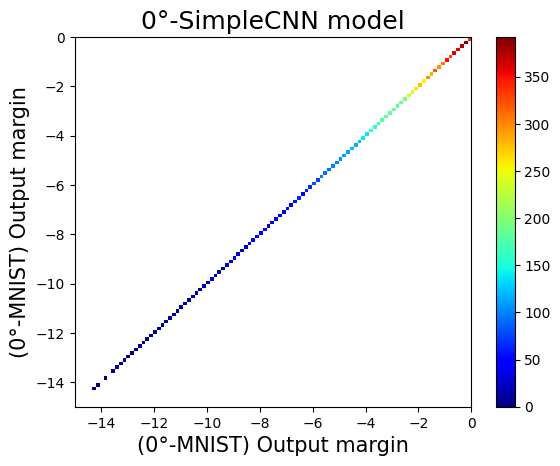

rotation_2 45


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

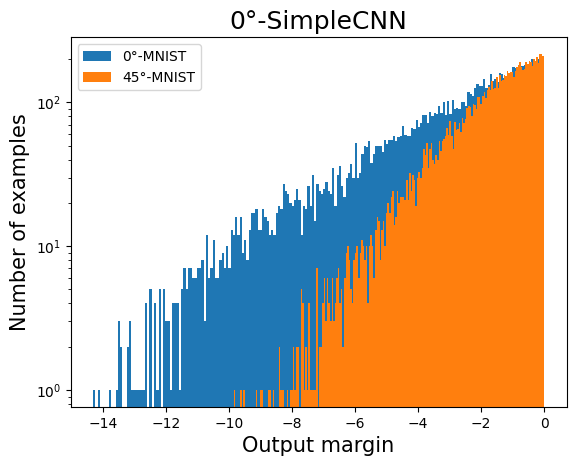

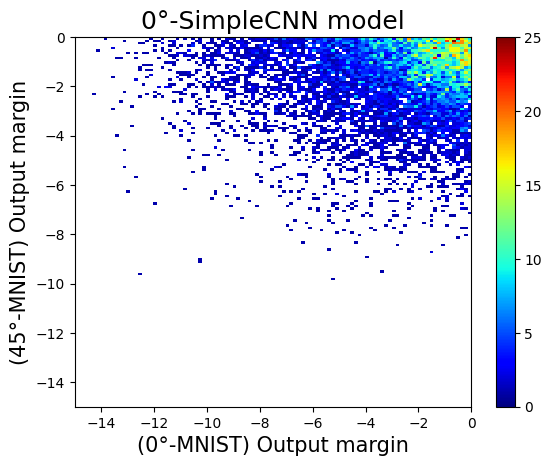

rotation_2 90


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

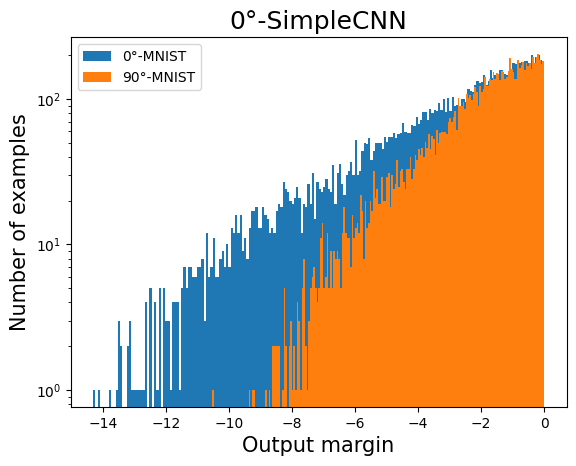

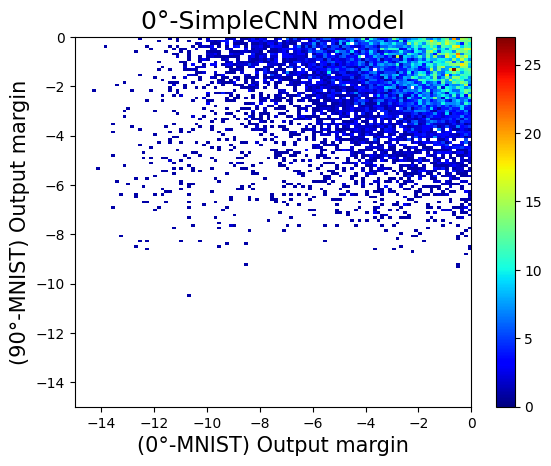

rotation_2 135


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

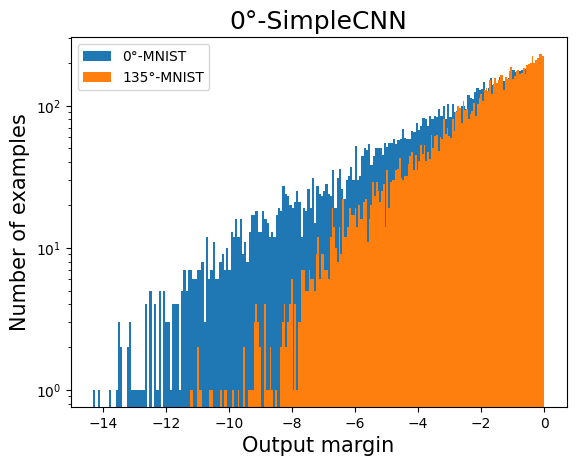

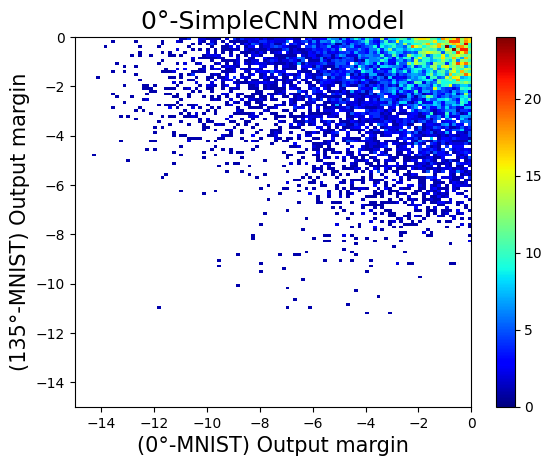

rotation_2 180


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

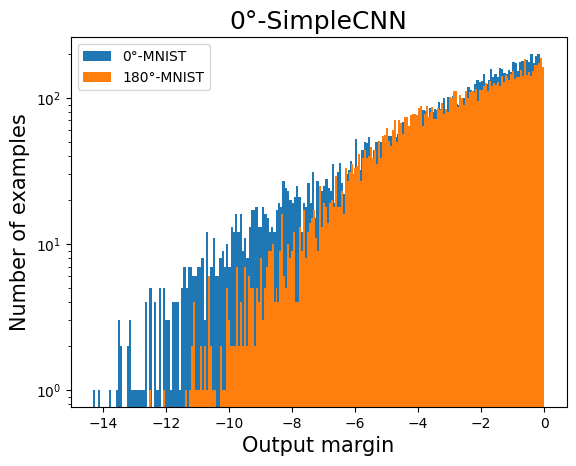

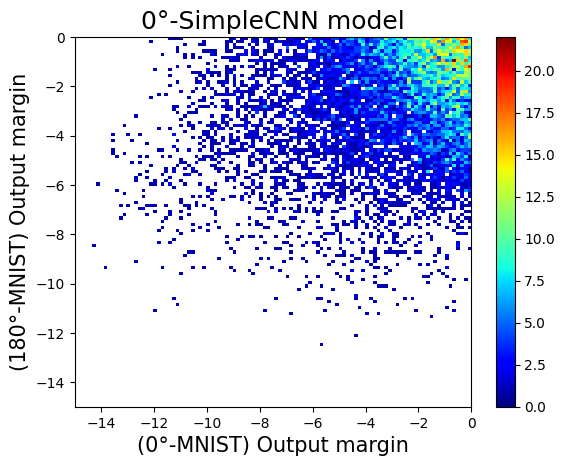

rotation_2 225


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

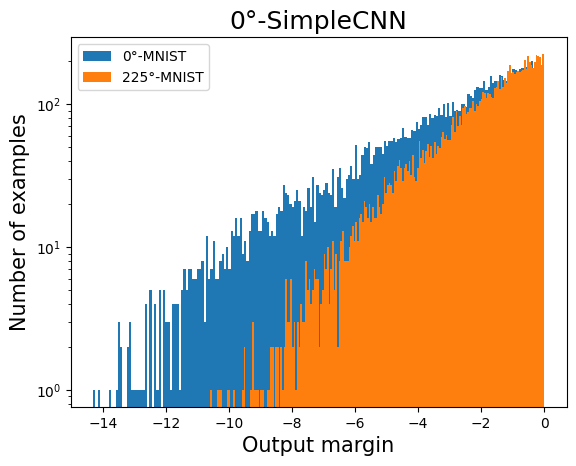

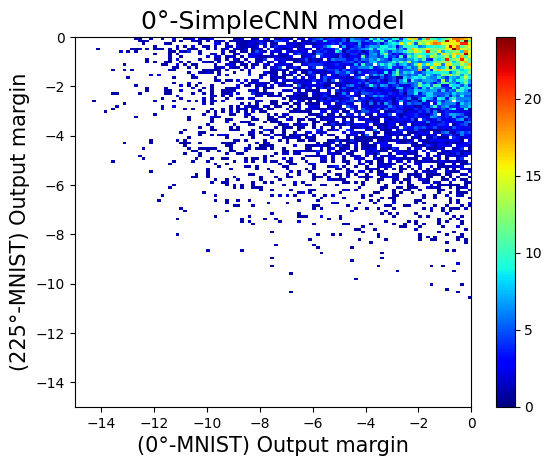

rotation_2 270


/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/hamidi/current-work/HAR/2023-07-clMetaEquiv/env/lib/python

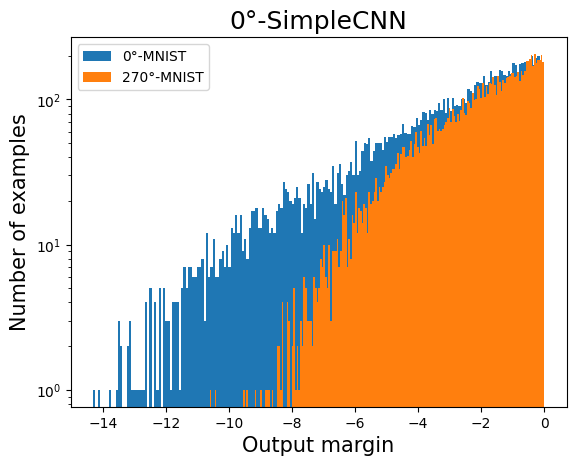

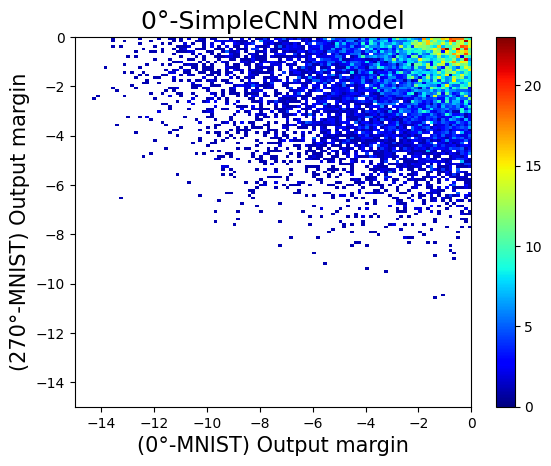

In [16]:
run_output_margins_analysis(model_id=1, config=config, xlim=[-15, 0], ylim=[-15, 0])

## Adversarial input margins